# model_test.csv 데이터 전처리

이 노트북은 model_test.csv 파일을 로드하고 전처리를 수행합니다.


In [18]:
import pandas as pd
import re

# 데이터 로드
data = pd.read_csv('model_test.csv')
print(f"원본 데이터 크기: {data.shape}")
print(f"원본 컬럼 수: {len(data.columns)}")


원본 데이터 크기: (10000, 69)
원본 컬럼 수: 69


## 전처리1 - target value 전처리
split_prescription는 한 줄짜리 운동 처방 문자열에서 준비운동:, 본운동:, 마무리운동/정리운동: 구간을 정규식으로 찾아 각각 Prep/Main/CoolDown 텍스트로 분리해서 시리즈로 돌려주는 함수입니다. 이렇게 구조화하면 전처리·모델링·서비스 단계에서 다루기가 훨씬 쉬워 집니다.

In [19]:
# 현재 데이터프레임 'data'에서 모델의 특징(X)과 정답(Y)을 지정하는 컬럼 목록을 정의
FEATURE_COLS = ['MESURE_AGE_CO', 'SEXDSTN_FLAG_CD', 'MESURE_IEM_001_VALUE', 'MESURE_IEM_002_VALUE']
TARGET_COL = 'MVM_PRSCRPTN_CN'

data = data[FEATURE_COLS + [TARGET_COL]].copy() # 특징 컬럼들과 정답 컬럼만 원본 데이터에서 추출하여 'data'에 복사
data[TARGET_COL] = data[TARGET_COL].fillna("") # 정답 컬럼에 결측값이 있을 경우 빈 문자열("")로 대체

def split_prescription(text):
    """운동 처방 문자열에서 각 단계별 운동(준비, 본, 마무리)을 찾아서 딕셔너리 형태로 정리해 반환"""
    sections = {'Prep': '', 'Main': '', 'CoolDown': ''}
    if not isinstance(text, str): text = ""

    prep_match = re.search(r'준비운동:(.*?)(?:\s*/\s*본운동:|$)', text)
    if prep_match: sections['Prep'] = prep_match.group(1).strip()

    main_match = re.search(r'본운동:(.*?)(?:\s*/\s*마무리운동:|\s*/\s*정리운동:|$)', text)
    if main_match: sections['Main'] = main_match.group(1).strip()

    cool_match = re.search(r'(?:마무리운동|정리운동):(.*)', text)
    if cool_match: sections['CoolDown'] = cool_match.group(1).strip()

    return pd.Series(sections)

# 정답 컬럼을 세 개의 섹션(Prep/Main/CoolDown)으로 확장
data_sections = data[TARGET_COL].apply(split_prescription)
data = pd.concat([data.drop(columns=[TARGET_COL]), data_sections], axis=1)

def split_to_list(text):
    """쉼표로 구분된 운동 텍스트를 리스트로 변환"""
    return [e.strip() for e in text.split(',') if e.strip()]

data['Prep_List'] = data['Prep'].apply(split_to_list)
data['Main_List'] = data['Main'].apply(split_to_list)
data['CoolDown_List'] = data['CoolDown'].apply(split_to_list)


## 전처리2-1 - 필요한 column만 추출
프론트에서 나이(Age), 성별(Gender), 키(Measure_001), 몸무게(Measure_002)  
- **feature(X)**: Age, Gender, Measure_001, Measure_002
- **target value(Y)**: Prep_Exercise, Main_Exercise, CoolDown_Exercise

In [20]:
# 학습에 필요한 컬럼만 선택 및 컬럼 이름 변경
# 입력 변수: Age, Gender, Measure_001, Measure_002
# 타깃 변수: Prep, Main, CoolDown (클래스 축소 전)

data = data[['MESURE_AGE_CO', 'SEXDSTN_FLAG_CD', 'MESURE_IEM_001_VALUE', 'MESURE_IEM_002_VALUE',
             'Prep', 'Main', 'CoolDown']].copy()

# 컬럼 이름 변경
data.columns = ['Age', 'Gender', 'Measure_001', 'Measure_002',
                'Prep', 'Main', 'CoolDown']

print("컬럼 정리 후 데이터 컬럼:")
print(data.columns.tolist())
print(f"\n컬럼 정리 후 데이터 크기: {data.shape}")


컬럼 정리 후 데이터 컬럼:
['Age', 'Gender', 'Measure_001', 'Measure_002', 'Prep', 'Main', 'CoolDown']

컬럼 정리 후 데이터 크기: (10000, 7)


## 전처리2-2 - 클래스 축소
타깃 클래스(운동 조합)가 너무 많아서 상위 N개만 남기고 나머지를 ‘기타’로 합쳐서 더 유의미 한 값이 반환되도록 하였습니다. 이렇게 하면 클래스 수가 2,000~4,000개에서 20~30개 수준으로 줄어서 학습 속도와 메모리 사용이 크게 줄고, 모델이 안정적으로 학습할 수있습니다.

In [21]:
def create_simplified_target(df, col_name, top_n=20):
    """
    상위 N개 조합만 사용하고 나머지는 '기타'로 통합
    (Weka 데이터 전처리 보고서 기준)
    
    Parameters:
    -----------
    df : DataFrame
        데이터프레임
    col_name : str
        축소할 컬럼명
    top_n : int
        유지할 상위 N개 조합 수
    
    Returns:
    --------
    new_col : Series
        축소된 컬럼 (상위 N개 + '기타' + '?')
    top_values : list
        상위 N개 값 리스트
    """
    # 결측값 제외 (빈 문자열도 결측으로 처리)
    valid_data = df[(df[col_name] != '?') & (df[col_name] != '') & (df[col_name].notna())][col_name]
    
    # 빈도 계산
    value_counts = valid_data.value_counts()
    
    # 상위 N개 선택
    top_values = value_counts.head(top_n).index.tolist()
    
    # 새로운 컬럼 생성
    new_col = df[col_name].copy()
    new_col = new_col.apply(lambda x: x if (x in top_values or x == '?' or x == '' or pd.isna(x)) else '기타')
    
    # 빈 문자열과 NaN을 '?'로 통일
    new_col = new_col.replace('', '?')
    new_col = new_col.fillna('?')
    
    return new_col, top_values


In [22]:
# Weka 데이터 전처리 보고서 기준에 따른 클래스 축소 적용
# Prep_Exercise: 상위 20개만 유지, 나머지는 '기타'로 통합
# Main_Exercise: 상위 30개만 유지, 나머지는 '기타'로 통합
# CoolDown_Exercise: 상위 20개만 유지, 나머지는 '기타'로 통합

# Prep_Exercise 축소
data['Prep_Exercise'], prep_top = create_simplified_target(data, 'Prep', top_n=20)
print(f"Prep_Exercise 상위 20개 클래스: {len(prep_top)}개")

# Main_Exercise 축소
data['Main_Exercise'], main_top = create_simplified_target(data, 'Main', top_n=30)
print(f"Main_Exercise 상위 30개 클래스: {len(main_top)}개")

# CoolDown_Exercise 축소
data['CoolDown_Exercise'], cooldown_top = create_simplified_target(data, 'CoolDown', top_n=20)
print(f"CoolDown_Exercise 상위 20개 클래스: {len(cooldown_top)}개")

# 최종 컬럼 선택
data_final = data[['Age', 'Gender', 'Measure_001', 'Measure_002',
                   'Prep_Exercise', 'Main_Exercise', 'CoolDown_Exercise']].copy()


Prep_Exercise 상위 20개 클래스: 20개
Main_Exercise 상위 30개 클래스: 30개
CoolDown_Exercise 상위 20개 클래스: 20개


## 전처리 완료 결과


In [23]:
data_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                10000 non-null  int64  
 1   Gender             10000 non-null  object 
 2   Measure_001        10000 non-null  float64
 3   Measure_002        10000 non-null  float64
 4   Prep_Exercise      10000 non-null  object 
 5   Main_Exercise      10000 non-null  object 
 6   CoolDown_Exercise  10000 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 547.0+ KB


## 데이터 분석 및 시각화


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### 1. 수치형 변수 Box Plot


C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3585122099.py:13: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3585122099.py:13: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3585122099.py:13: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3585122099.py:13: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3585122099.py:13: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3585122099.py:13: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) Arial.
  plt.tight_layou

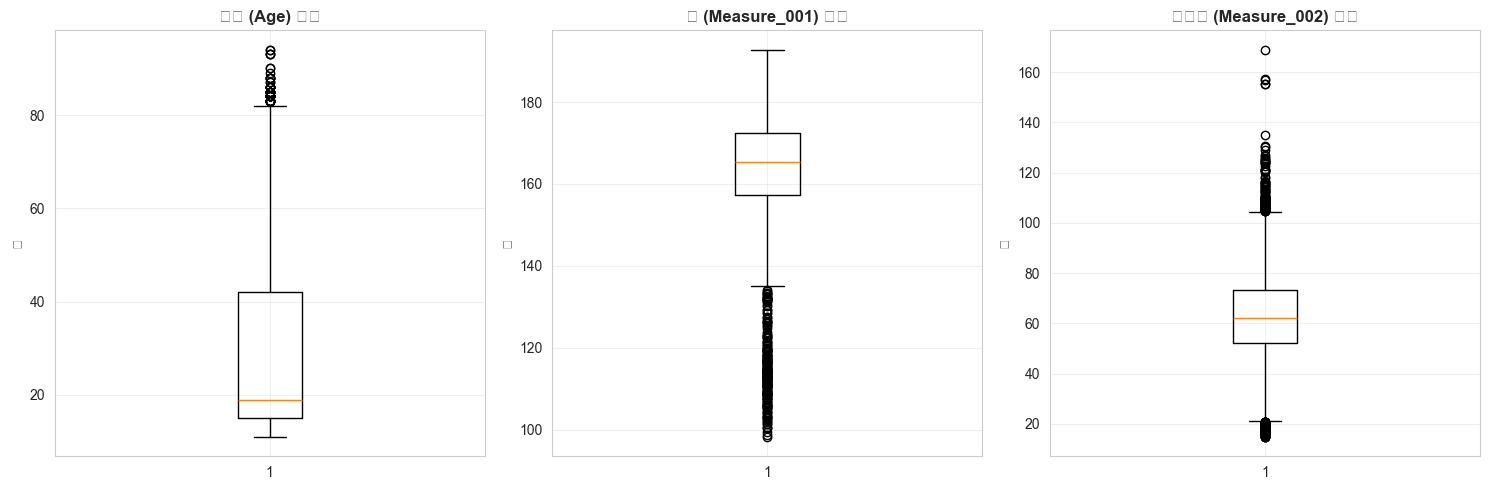

수치형 변수 통계 요약:
                Age   Measure_001   Measure_002
count  10000.000000  10000.000000  10000.000000
mean      29.814900    163.978401     62.911010
std       20.783129     12.555255     16.505459
min       11.000000     98.200000     14.800000
25%       15.000000    157.300000     52.300000
50%       19.000000    165.400000     62.100000
75%       42.000000    172.500000     73.200000
max       94.000000    192.800000    168.900000


In [ ]:
# 수치형 변수들의 분포를 Box Plot으로 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

numeric_cols = ['Age', 'Measure_001', 'Measure_002']
col_names = ['나이 (Age)', '키 (Measure_001)', '몸무게 (Measure_002)']

for idx, (col, name) in enumerate(zip(numeric_cols, col_names)):
    axes[idx].boxplot(data_final[col].dropna(), vert=True)
    axes[idx].set_title(f'{name} 분포', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('값', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 요약
print("수치형 변수 통계 요약:")
print(data_final[numeric_cols].describe())


### 2. 타깃 변수별 수치형 변수 Box Plot


C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3805093108.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[prep[:15] + '...' if len(prep) > 15 else prep for prep in prep_top5],
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3805093108.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[prep[:15] + '...' if len(prep) > 15 else prep for prep in prep_top5],
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\3805093108.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[prep[:15] + '...' if le

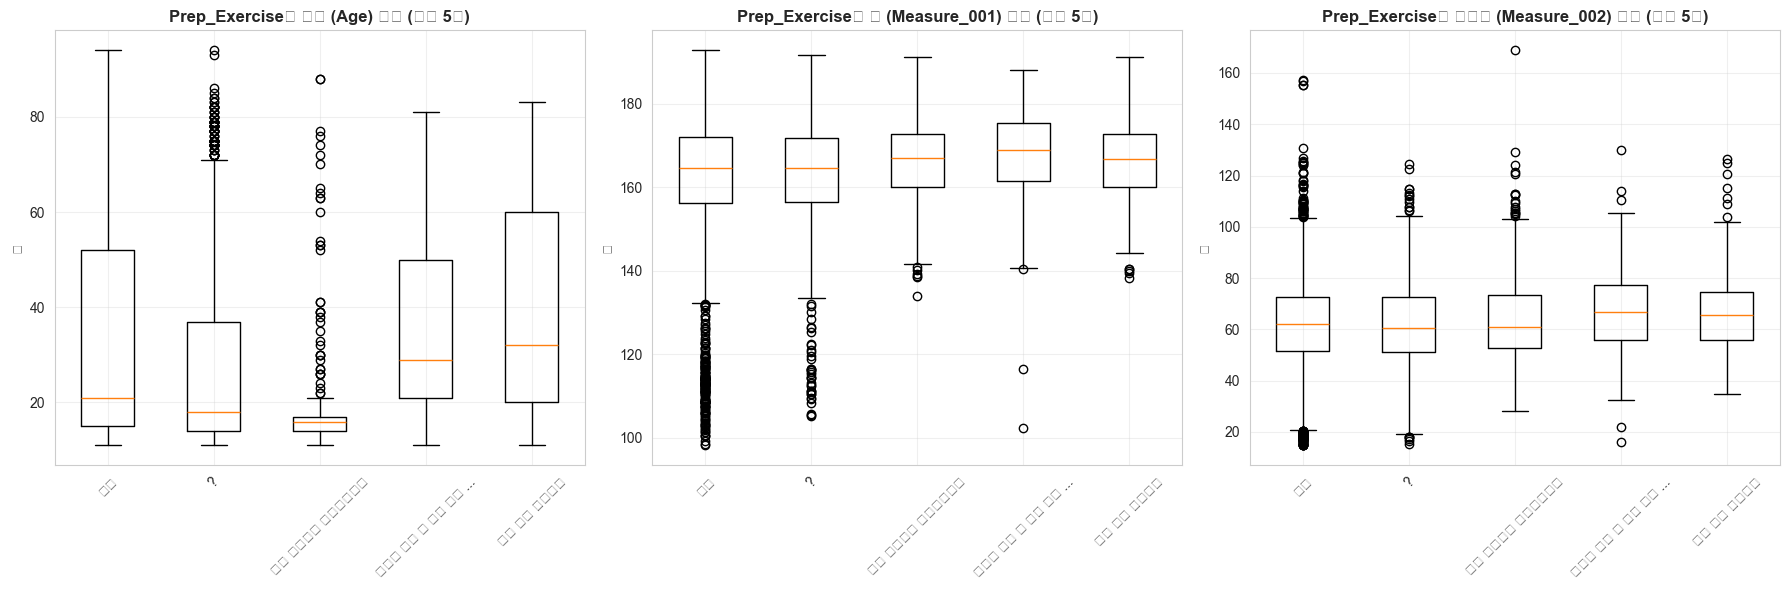

In [ ]:
# Prep_Exercise별 수치형 변수 분포 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 상위 5개 Prep_Exercise만 선택 (가독성을 위해)
prep_top5 = data_final['Prep_Exercise'].value_counts().head(5).index.tolist()
data_prep_top5 = data_final[data_final['Prep_Exercise'].isin(prep_top5)]

numeric_cols = ['Age', 'Measure_001', 'Measure_002']
col_names = ['나이 (Age)', '키 (Measure_001)', '몸무게 (Measure_002)']

for idx, (col, name) in enumerate(zip(numeric_cols, col_names)):
    data_to_plot = [data_prep_top5[data_prep_top5['Prep_Exercise'] == prep][col].dropna().values 
                    for prep in prep_top5]
    axes[idx].boxplot(data_to_plot, labels=[prep[:15] + '...' if len(prep) > 15 else prep for prep in prep_top5], 
                      vert=True)
    axes[idx].set_title(f'Prep_Exercise별 {name} 분포 (상위 5개)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('값', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3. 수치형 변수 히스토그램


C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\656386652.py:14: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\656386652.py:14: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\656386652.py:14: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\656386652.py:14: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\656386652.py:14: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\656386652.py:14: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
C

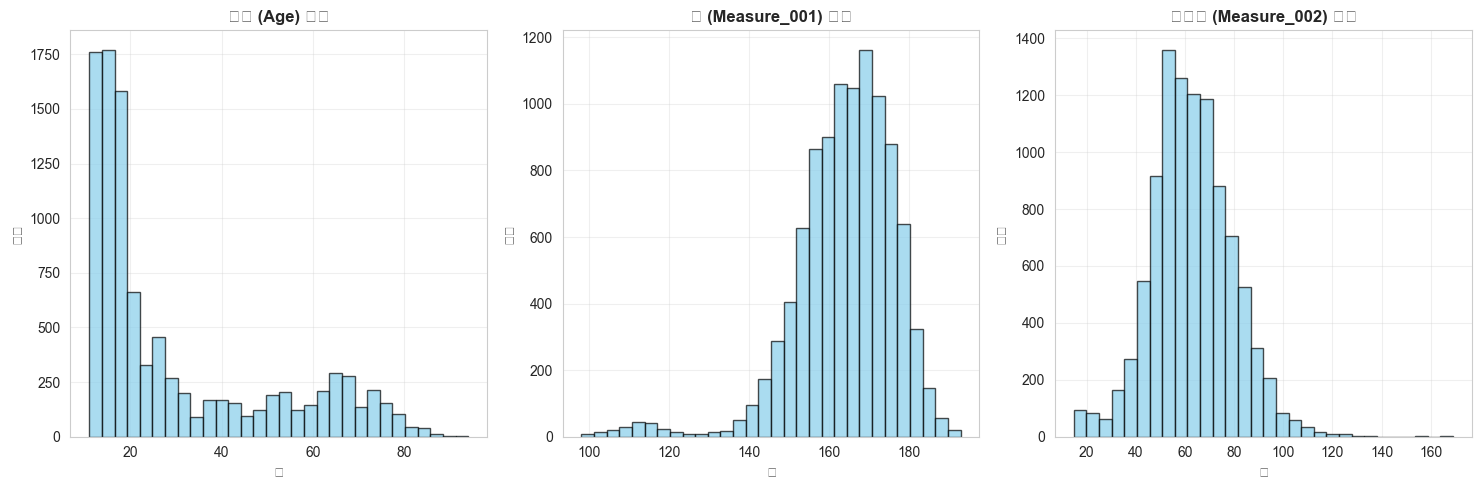

In [ ]:
# 수치형 변수들의 분포를 히스토그램으로 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

numeric_cols = ['Age', 'Measure_001', 'Measure_002']
col_names = ['나이 (Age)', '키 (Measure_001)', '몸무게 (Measure_002)']

for idx, (col, name) in enumerate(zip(numeric_cols, col_names)):
    axes[idx].hist(data_final[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{name} 분포', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('값', fontsize=10)
    axes[idx].set_ylabel('빈도', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4. 범주형 변수 분포


C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\1458737883.py:41: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\1458737883.py:41: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\1458737883.py:41: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\1458737883.py:41: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\1458737883.py:41: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oculo\AppData\Local\Temp\ipykernel_16192\1458737883.py:41: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) Arial.
  plt.tight

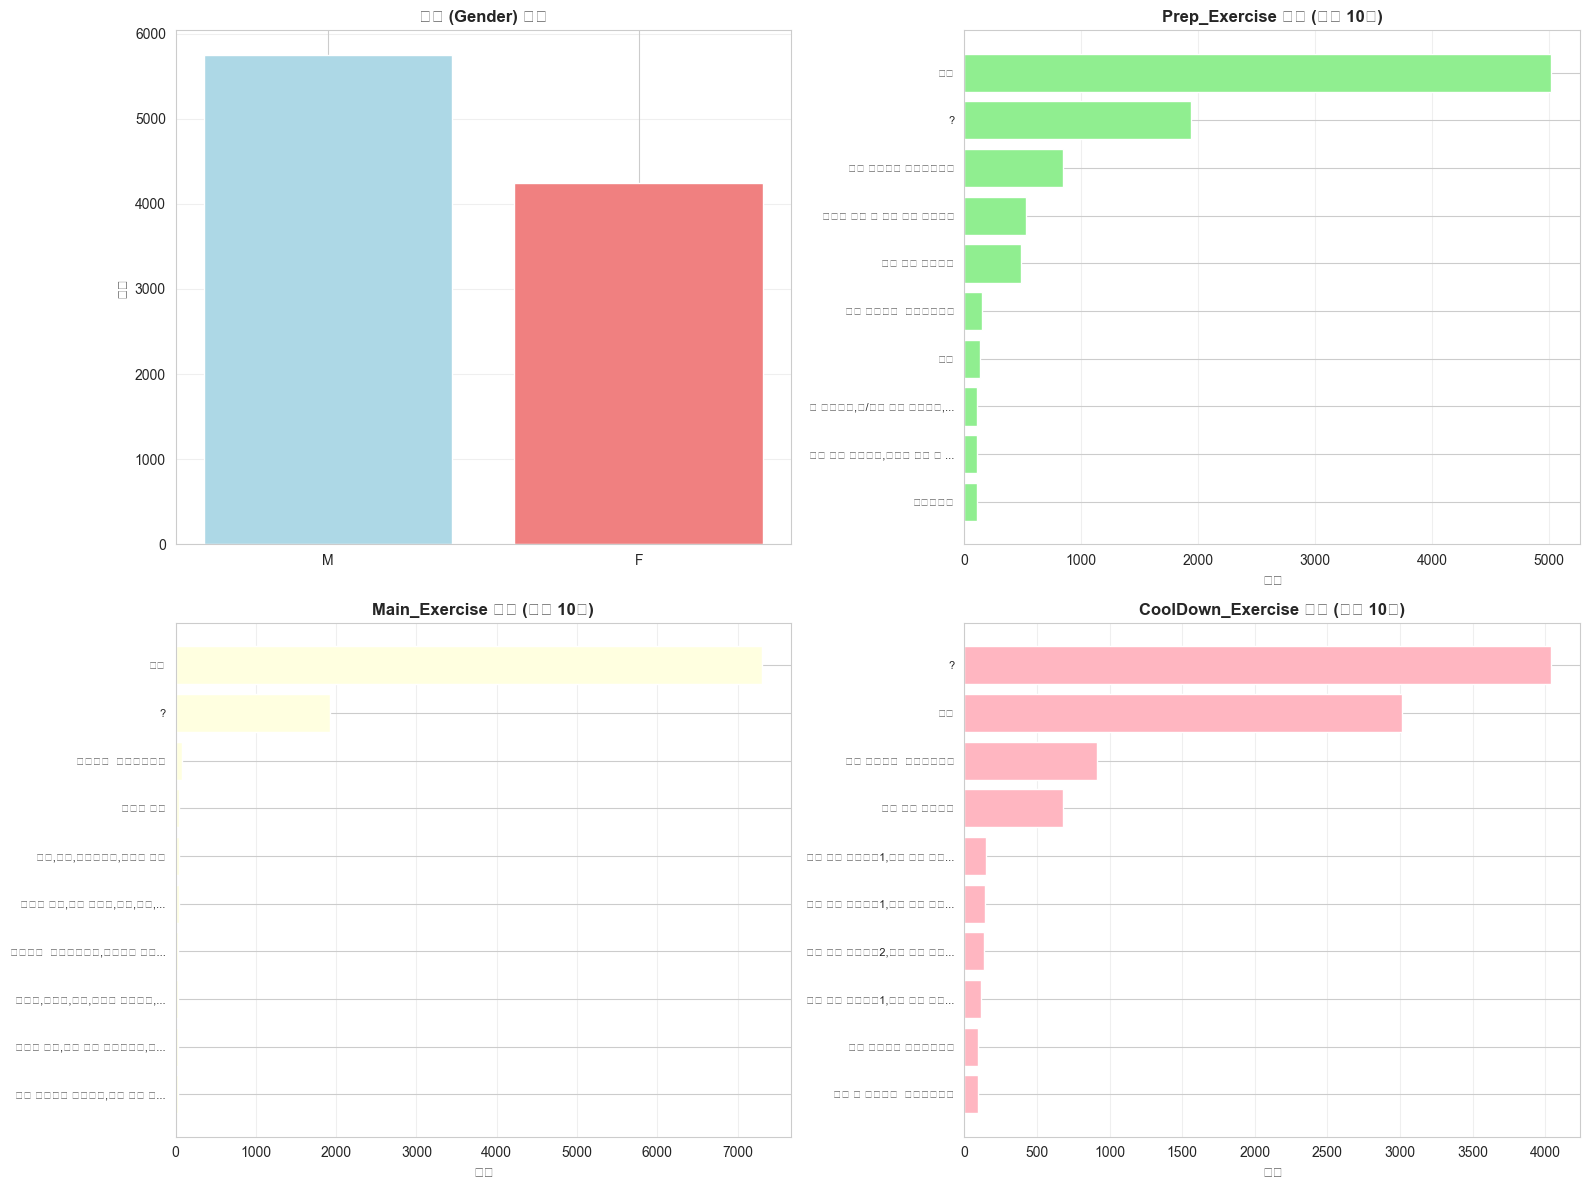

In [ ]:
# 범주형 변수들의 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gender 분포
gender_counts = data_final['Gender'].value_counts()
axes[0, 0].bar(gender_counts.index, gender_counts.values, color=['lightblue', 'lightcoral'])
axes[0, 0].set_title('성별 (Gender) 분포', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('빈도', fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Prep_Exercise 상위 10개
prep_top10 = data_final['Prep_Exercise'].value_counts().head(10)
axes[0, 1].barh(range(len(prep_top10)), prep_top10.values, color='lightgreen')
axes[0, 1].set_yticks(range(len(prep_top10)))
axes[0, 1].set_yticklabels([label[:20] + '...' if len(label) > 20 else label for label in prep_top10.index], fontsize=8)
axes[0, 1].set_title('Prep_Exercise 분포 (상위 10개)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('빈도', fontsize=10)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Main_Exercise 상위 10개
main_top10 = data_final['Main_Exercise'].value_counts().head(10)
axes[1, 0].barh(range(len(main_top10)), main_top10.values, color='lightyellow')
axes[1, 0].set_yticks(range(len(main_top10)))
axes[1, 0].set_yticklabels([label[:20] + '...' if len(label) > 20 else label for label in main_top10.index], fontsize=8)
axes[1, 0].set_title('Main_Exercise 분포 (상위 10개)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('빈도', fontsize=10)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# CoolDown_Exercise 상위 10개
cooldown_top10 = data_final['CoolDown_Exercise'].value_counts().head(10)
axes[1, 1].barh(range(len(cooldown_top10)), cooldown_top10.values, color='lightpink')
axes[1, 1].set_yticks(range(len(cooldown_top10)))
axes[1, 1].set_yticklabels([label[:20] + '...' if len(label) > 20 else label for label in cooldown_top10.index], fontsize=8)
axes[1, 1].set_title('CoolDown_Exercise 분포 (상위 10개)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('빈도', fontsize=10)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 이후 WEKA에서 학습하고, 서비스에 적용하는 과정
- python 파일을 이용한 arff 변환
weka를 통해 모델 학습을 진행하고 .model형식으로 저장하여 spring boot 서버에 적용할 예정입니다. 따라서 arff 변환이 필요했습니다.

* Prep Exercise
LMT가 10-fold 교차 검증에서 70.2605% 정확도를 보여, 베이스라인보다는 분명 향상된 성능이지만 목표로 했던 수준(예: 80% 이상)에는 다소 못 미치는 결과였습니다. 다만 입력 특성이 4개뿐이고 클래스 수가 많은 멀티클래스 문제라는 점을 고려하면, 추가 피처 확장·하이퍼파라미터 튜닝을 통해 개선 여지가 있는 합리적인 출발점으로 볼 수 있습니다.

* Main Exercise
LMT가 10-fold 교차 검증에서 91.3851%의 높은 정확도를 기록해, 세 목표 변수 중 가장 안정적이고 신뢰도 높은 예측 성능을 보였습니다. 특히 클래스 수를 크게 축소한 상태에서도 90%를 넘는 정확도를 달성했다는 점에서, 실서비스에서 메인 운동 추천의 핵심 모델로 활용하기에 충분히 유의미한 결과입니다.

* CoolDown Exercise
- WEKA에서는 RandomForest, LMT, J48, DecisionStump, HoeffdingTree, RandomTree, REPTree를 시도해보았고 LMT가 cross validation folds 10 으로 확인했을 때 63.6028%로 가장 성능이 좋았습니다.

- 80퍼센트 이하의 결과이기 때문에 실험 결과 자체로만 보면 매우 유의미하다고 볼 수 없으나, 실제 spring에서 적용할 api에서 top3까지 보여줄 것이기 때문에 완전히 무의미한 결과를 도출한다고 볼수는 없습니다. 클래스 수(22~32개)와 현재 Top‑1 정확도(약 63.6%)를 감안하면 Top‑3 정확도는 Top‑1보다 꽤 크게 올라갈 가능성이 높고, 따라서 실서비스에서 “Top3 추천” 방식은 충분히 실용성이 있을 수 있습니다.